In [44]:
!pip install eli5

In [45]:
!pip install category_encoders

In [7]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


#import eli5
#from eli5.sklearn import PermutationImportance
#import category_encoders as ce
#from catboost import CatBoostClassifier

In [8]:
# pitcher = 'Verlander'
# pitcher = 'Greinke'
# pitcher = 'Scherzer'
# pitcher = 'deGrom'
# pitcher = 'Bauer'
# pitcher = 'Gibson'
# pitcher = 'Lynn'
pitcher = 'Corbin'
# pitcher = 'Cole'
# pitcher = 'Nola'

path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/' + pitcher + '_df.pkl'

df = pd.read_pickle(path, compression='zip').reset_index()

#make binary fastball/not-fastball target feature:
# df['fastball_target'] = (df['pitch_cat'] == 'fastball') * 1

In [9]:
#replace some categoricals with custom strategic ordinal encoding scale:

def custom_ordinal_ecode(df):
    df = df.copy()
        
    #description cols:
    desc_map = {'called_strike':1,
                'swinging_strike':2,
                'foul_tip':3,
                'foul':4,
                'swinging_strike_blocked':5,
                'foul_bunt':6,
                'missed_bunt':6,
                'bunt_foul_tip':6,
                'N/A':7,
                'pitchout':7,
                'hit_into_play':8,
                'ball':9,
                'blocked_ball':10,
                'hit_by_pitch':11,
                'hit_into_play_no_out':12,
                'hit_into_play_score':13}
    
    desc_cols = ['L1_description', 'L2_description', 'L3_description']
    df[desc_cols] = df[desc_cols].replace(desc_map).astype('int')

    #pitch_result cols
    pitch_result_map = {'S':1, 'N/A':2, 'X':3, 'B':4}
    result_cols = ['L1_pitch_result', 'L2_pitch_result']
    df[result_cols] = df[result_cols].replace(pitch_result_map).astype('int')

    #pitch_type cols
    pitch_type_map = {'FA':1, 'FF':1, 'FT':2, 'FC':2, 'FS':2, 'SI':2, 'SF':2, 'N/A':2.5, 'SL':3,
                      'CB':4, 'CU':4, 'SC':5, 'KC':5, 'CH':6, 'KN':7, 'EP':8, 'FO':9, 'PO':9}
    pitch_type_cols = ['L1_pitch_type', 'L2_pitch_type', 'L3_pitch_type', 'pitch_type']
    df[pitch_type_cols] = df[pitch_type_cols].replace(pitch_type_map).astype('float')

    #count_cat
    count_cat_map = {'ahead':1,'neutral':2, 'behind':3}
    df['count_cat'] = df['count_cat'].replace(count_cat_map).astype('int')

    #count
    _count_map = {'02':1, '12':2, '01':3, '22':4, '11':5, '00':6, '21':7, '32':8, '10':9, '20':10, '31':11, '30':12}
    df['_count'] = df['_count'].replace(_count_map).astype('int')

    #for swung and chased, make unknown (-1) set to 0, and 0 (didnt swing/chase) set to -1:
    swung_and_chased_cols = ['L1_batter_swung', 'L1_chased', 'L2_chased', 'L3_chased']

    def swung_chase_edit(x):
        if x == 0:
            return -1
        elif x == -1:
            return 0
        else:
            return x

    for col in swung_and_chased_cols:
        df[col] = df[col].apply(swung_chase_edit)

    #fill remaining misc categories to numerics:
    misc_map = {'L':-1, 'R':2, 'Top':-1, 'Bot': 1, 'Standard':0, 'Infield shift': 1, 'Strategic':2, '4th outfielder':3}
    df = df.replace(misc_map)

    #clean up category dtypes to ints
    df['year'] = df['year'].cat.codes
    df['catcher_id'] = df['catcher_id'].cat.codes
    
    cat_cols = ['outs_when_up', 'inning', 'at_bat_number', 'pitch_number', 'balls', 'strikes', 'pitch_count', 'L1_pitch_zone', 
                'L1_batter_swung', 'L1_chased', 'L2_pitch_zone', 'L2_chased', 'L3_pitch_zone', 'L3_chased', 'batting_order_slot', 
                'month']
    
    df[cat_cols] = df[cat_cols].astype('int')
    df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']] = df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']].astype('int')
    return df

def one_hot_encode(df):
    
    cat_cols = df.select_dtypes('category').columns.tolist()
    debug_pitcher_list = ['Cole', 'Bauer']
    if pitcher == 'Cole' or pitcher == 'Bauer':
        cat_cols = cat_cols + df.select_dtypes('object').columns.tolist()
    ignore_cols = ['at_bat_number', 'pitch_count', 'pitch_cat', 'player_name', 'pitch_type', 'pitcher']
    for col in ignore_cols:
        try:
            cat_cols.remove(col)
            #print(col + ' removed')
        except:
            print(col + ' not found')
    pitch_type_map = {'FA':1, 'FF':1, 'FT':2, 'FC':2, 'FS':2, 'SI':2, 'SF':2, 'N/A':2.5, 'SL':3,
                      'CB':4, 'CU':4, 'SC':5, 'KC':5, 'CH':6, 'KN':7, 'EP':8, 'FO':9, 'PO':9}
    df['pitch_type'] = df['pitch_type'].replace(pitch_type_map).astype('float')
    df[['at_bat_number', 'pitch_count']] = df[['at_bat_number', 'pitch_count']].astype('int')
    df = pd.get_dummies(df, columns=cat_cols)
    return df

def pca_function(df, threshold, show_scree_plot=True, scaled=False, scaler_type='standard', excluded_cols=None):
    '''
    Takes a pandas dataframe and a desired threshold, scales the numeric features 
    and performs principal component analysis dimension reduction, and returns
    a pandas dataframe of lower dimensionality and variance explained to the given
    threshold

    Parameters
    ----------
    df : pandas dataframe
      The dataframe containing data to perform PCA on

    threshold : The desired % of variance explained to be included in the return;
              must be an number between 0 and 100

    show_scree_plot : Bool indicating whether or not to display scree plot showing 
                    the % variance explained by each principal component; 
                    default set to True

    scaled : Bool indicating whether the numeric data has been scaled; default set 
           to False

    exclude_cols : list of numeric columns to exclude from PCA; default set to None

    Returns
    -------
    dataframe:
      a pandas dataframe where the numeric columns have been scaled and 
      dimensions reduced to the number of principal components which explain
      the variance at a given threshold
    '''

    #confirm proper threshold input:
    if threshold < 1 or threshold > 100:
        return 'Incorrect threshold input, must be a number between 1 and 100'

    #library imports
    from sklearn.decomposition import PCA 
    from sklearn.preprocessing import StandardScaler, RobustScaler
    import seaborn as sns

    X = df.copy()

    if excluded_cols != None:
        X = X.drop(columns=excluded_cols)

    #use only the numeric columns that have not been excluded
    numeric_cols = X.select_dtypes(include='number').columns.tolist()
    X = X[numeric_cols].values

    if scaled == False:
        #scale the data:
        if scaler_type == 'standard':
            scaler = StandardScaler()
            scaled_X = scaler.fit_transform(X)
        elif scaler_type == 'robust':
            scaler = RobustScaler()
            scaled_X = scaler.fit_transform(X)        
    else:
        scaled_X = X

    #calc the principal component variance
    n = len(numeric_cols)
    covar_matrix = PCA(n_components = n)
    covar_matrix.fit(scaled_X)

    ##calculate variance ratios
    variance = covar_matrix.explained_variance_ratio_
    cumulative_var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

    #function for calculating number of principal components to use:
    def calc_num_components(cum_var, threshold):
        for i in range(n):
            if cum_var[i] >= threshold:
                return i+1

    #call the function to calulate num_components:
    n_components = calc_num_components(cumulative_var, threshold)

    # create the PCA instance
    pca = PCA(n_components = n_components)
    principal_components = pca.fit_transform(scaled_X)

    #scree plot function
    '''
    colors = ['red' if x == n_components else 'grey' for x in X_vals]
    sb.barplot(x=idx, y=values, palette=colors)'''

    def make_scree(cumulative_variance, threshold):
        import matplotlib.pyplot as plt
        import seaborn as sns

        n = len(cumulative_variance)
        y_vals = [num for num in cumulative_variance]
        x_vals = [num for num in range(1,n+1)]

        colors = ['red' if x == n_components else '#769ddb' for x in x_vals]
        width = min(n/3, 20)
        height = min(n/4, 16)
        fig, ax = plt.subplots(figsize=(width,height))
        ax.grid(True)
        ax.set_title('Principal Components Cumulative Variance')
        ax.set_ylabel('Cumulative Variance % Explained')
        ax.set_xlabel('Principal Components')

        # threshold var
        ax.axhline(threshold, color='black', linewidth=1);
        sns.barplot(x=x_vals, y=y_vals, ax=ax, palette=colors)
        plt.show()

    if show_scree_plot:
        #plot it:
        make_scree(cumulative_var, threshold)

    #convert to pandas df:
    pc_df = pd.DataFrame(data = principal_components, columns=['component_' + str(i) for i in range(1, n_components+1)])

    #return df which is original df w/ the numeric cols dropped and replaced w/ principal components df

    df = pd.concat([df, pc_df], axis=1).drop(columns = numeric_cols)
    return df

In [11]:
#for Verlander, who only threw 20 cut fastballs, just recast as 4seam fastball 
#(not worth treating as own class, possibly misclassified anyway).. similar for Cole

if pitcher == 'Verlander':
    df = df.replace({'FC':'FF'})  
if pitcher == 'Cole':
    df = df.replace({'FT':'FF'})
if pitcher == 'Bauer':
    df = df.replace({'FT':'FC'})
    
#fill NaNs for pitcher Lynn in the pitchout percentage columns:
if pitcher == 'Lynn':
    df[['overall_pitchout_perc', 'count_cat_pitchout_perc']] = df[['overall_pitchout_perc', 'count_cat_pitchout_perc']].fillna(0.0)

#For Corbin, gonna try combining all fastballs together
if pitcher == 'Corbin':
    df['pitch_type'] = df['pitch_type'].replace({2.0:1.0})
    
df.pitch_type.value_counts(normalize=True)

SL    0.390081
FT    0.310966
FF    0.199417
CU    0.067445
CH    0.032092
Name: pitch_type, dtype: float64

In [51]:
def cat_encode(df, encode_type):
    if encode_type == 'one_hot':
        return one_hot_encode(df)
    elif encode_type == 'custom_ordinal':
        return custom_ordinal_ecode(df)


df = cat_encode(df, 'one_hot')
# df = cat_encode(df, 'custom_ordinal')

df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,sz_top,sz_bot,at_bat_number,bat_score,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,player_name,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_breaking_perc,count_cat_breaking_perc,overall_offspeed_perc,count_cat_offspeed_perc,pitch_count,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_offspeed,PB_breaking,on_base,outs_when_up_0.0,outs_when_up_1.0,outs_when_up_2.0,inning_1.0,inning_2.0,inning_3.0,inning_4.0,inning_5.0,inning_6.0,inning_7.0,inning_8.0,inning_17.0,catcher_id_435064.0,catcher_id_460269.0,catcher_id_488771.0,catcher_id_553902.0,catcher_id_641598.0,pitch_number_1.0,pitch_number_2.0,pitch_number_3.0,pitch_number_4.0,pitch_number_5.0,pitch_number_6.0,pitch_number_7.0,pitch_number_8.0,pitch_number_9.0,pitch_number_10.0,pitch_number_11.0,pitch_number_12.0,pitch_number_13.0,stand_L,stand_R,inning_topbot_Bot,inning_topbot_Top,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,balls_0,balls_1,balls_2,balls_3,strikes_0,strikes_1,strikes_2,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,_count_00,_count_01,_count_02,_count_10,_count_11,_count_12,_count_20,_count_21,_count_22,_count_30,_count_31,_count_32,count_cat_ahead,count_cat_behind,count_cat_neutral,L1_pitch_type_CH,L1_pitch_type_CU,L1_pitch_type_FF,L1_pitch_type_FT,L1_pitch_type_N/A,L1_pitch_type_SL,L1_pitch_result_B,L1_pitch_result_N/A,L1_pitch_result_S,L1_pitch_result_X,L1_description_N/A,L1_description_ball,L1_description_blocked_ball,L1_description_called_strike,L1_description_foul,L1_description_foul_bunt,L1_description_foul_tip,L1_description_hit_by_pitch,L1_description_hit_into_play,L1_description_hit_into_play_no_out,L1_description_hit_into_play_score,L1_description_missed_bunt,L1_description_swinging_strike,L1_description_swinging_strike_blocked,L1_pitch_zone_-1.0,L1_pitch_zone_1.0,L1_pitch_zone_2.0,L1_pitch_zone_3.0,L1_pitch_zone_4.0,L1_pitch_zone_5.0,L1_pitch_zone_6.0,L1_pitch_zone_7.0,L1_pitch_zone_8.0,L1_pitch_zone_9.0,L1_pitch_zone_11.0,L1_pitch_zone_12.0,L1_pitch_zone_13.0,L1_pitch_zone_14.0,L1_batter_swung_-1.0,L1_batter_swung_0.0,L1_batter_swung_1.0,L1_chased_-1.0,L1_chased_0.0,L1_chased_1.0,L2_pitch_type_CH,L2_pitch_type_CU,L2_pitch_type_FF,L2_pitch_type_FT,L2_pitch_type_N/A,L2_pitch_type_SL,L2_pitch_result_B,L2_pitch_result_N/A,L2_pitch_result_S,L2_pitch_result_X,L2_description_N/A,L2_description_ball,L2_description_blocked_ball,L2_description_called_strike,L2_description_foul,L2_description_foul_bunt,L2_description_foul_tip,L2_description_hit_by_pitch,L2_description_hit_into_play,L2_description_hit_into_play_no_out,L2_description_hit_into_play_score,L2_description_missed_bunt,L2_description_swinging_strike,L2_description_swinging_strike_blocked,L2_pitch_zone_-1.0,L2_pitch_zone_1.0,L2_pitch_zone_2.0,L2_pitch_zone_3.0,L2_pitch_zone_4.0,L2_pitch_zone_5.0,L2_pitch_zone_6.0,L2_pitch_zone_7.0,L2_pitch_zone_8.0,L2_pitch_zone_9.0,L2_pitch_zone_11.0,L2_pitch_zone_12.0,L2_pitch_zone_13.0,L2_pitch_zone_14.0,L2_chased_-1.0,L2_chased_0.0,L2_chased_1.0,L3_pitch_type_CH,L3_pitch_type_CU,L3_pitch_type_FF,L3_pitch_type_FT,L3_pitch_type_N/A,L3_pitch_type_SL,L3_description_N/A,L3_description_ball,L3_description_blocked_ball,L3_description_called_strike,L3_description_foul,L3_description_f

### PCA

In [54]:
# pca = True
pca = False

threshold = 99.45
excluded_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type']

if pca:
    pca_df = pca_function(df, threshold, show_scree_plot=True, scaled=True, scaler_type= 'robust', excluded_cols=excluded_cols)
    pca_df.head()

## Split into Train/Test

In [55]:
def train_test_split_by_date(df, train_fraction):
    train_idx = int(len(df) * train_fraction)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    print('train shape: ' + str(train.shape))
    print('test shape: '+ str(test.shape))
    return train, test

In [56]:
if pca:
    train, test = train_test_split_by_date(pca_df, .85)
else:
    train, test = train_test_split_by_date(df, .85)

train shape: (4858, 266)
test shape: (891, 266)


In [57]:
target = 'pitch_type'
#target = 'fastball_target'

#drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]
drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

((4858, 260), (891, 260), (4858,), (891,))

In [58]:
y.value_counts(normalize=True)

2.0    0.340263
1.0    0.214903
3.0    0.210169
6.0    0.122273
4.0    0.112392
Name: pitch_type, dtype: float64

In [59]:
y_test.value_counts(normalize=True)

2.0    0.307520
3.0    0.199776
1.0    0.191919
6.0    0.166105
4.0    0.134680
Name: pitch_type, dtype: float64

## Scale the Float columns

In [60]:
scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()
if pca == False:
    X[scale_cols] = scaler.fit_transform(X[scale_cols].values)
    X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

In [61]:
X.shape, X_test.shape, y.shape, y_test.shape

((4858, 260), (891, 260), (4858,), (891,))

## Random Forest

In [21]:
%%time

#with bootstrap:

param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 200, 300],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'min_samples_split': [5, 8, 12, 18, 25],
    'min_samples_leaf': [3, 5, 7, 10],
    'max_features': ['auto', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'warm_start': [False, True],
    'oob_score': [False, True]
}

rfc_with_bootstrap = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', bootstrap=True)

# search = GridSearchCV(
#     estimator = rfc, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True)

rfc_with_bootstrap_search = RandomizedSearchCV(estimator=rfc_with_bootstrap, param_distributions=param_grid, n_iter=300, 
                            scoring={'Accuracy':'accuracy', 'Balanced_accuracy':'balanced_accuracy'}, n_jobs=-1, iid='warn', refit='Accuracy', cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

rfc_with_bootstrap_search.fit(X, y)

rfc_bootstrap_search_results = pd.DataFrame(rfc_with_bootstrap_search.cv_results_).sort_values(by='rank_test_Accuracy')

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

CPU times: user 16.7 s, sys: 6.16 s, total: 22.8 s
Wall time: 6min 36s


In [22]:
rfc_bootstrap_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_oob_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Balanced_accuracy,split1_test_Balanced_accuracy,split2_test_Balanced_accuracy,mean_test_Balanced_accuracy,std_test_Balanced_accuracy,rank_test_Balanced_accuracy,split0_train_Balanced_accuracy,split1_train_Balanced_accuracy,split2_train_Balanced_accuracy,mean_train_Balanced_accuracy,std_train_Balanced_accuracy
276,1.283145,0.083889,0.561637,0.089108,True,True,125,5,3,auto,4,None,"{'warm_start': True, 'oob_score': True, 'n_est...",0.452619,0.488810,0.452241,0.464559,0.017151,1,0.499411,0.488954,0.518399,0.502255,0.012188,0.290716,0.352590,0.336232,0.326502,0.026185,198,0.374149,0.358279,0.389955,0.374128,0.012932
178,1.270003,0.122291,0.894931,0.155743,False,True,25,8,10,auto,6,None,"{'warm_start': False, 'oob_score': True, 'n_es...",0.434373,0.485277,0.451651,0.457098,0.021140,2,0.530053,0.516937,0.534884,0.527291,0.007583,0.284524,0.360402,0.335872,0.326921,0.031623,197,0.409561,0.401908,0.410183,0.407218,0.003763
1,3.639285,0.216937,1.393852,0.132487,False,False,300,8,5,0.5,2,None,"{'warm_start': False, 'oob_score': False, 'n_e...",0.443790,0.502356,0.418632,0.454938,0.035072,3,0.474956,0.477761,0.492788,0.481835,0.007829,0.289948,0.377607,0.314047,0.327199,0.036982,196,0.373325,0.359302,0.390862,0.374497,0.012911
85,1.710974,0.277859,0.773051,0.187189,False,False,150,25,5,auto,6,None,"{'warm_start': False, 'oob_score': False, 'n_e...",0.430253,0.488810,0.442217,0.453760,0.025265,4,0.538892,0.516642,0.539005,0.531513,0.010515,0.282478,0.362360,0.330821,0.325209,0.032860,200,0.414665,0.399211,0.417077,0.410318,0.007915
77,2.846613,0.106674,1.362875,0.072144,False,False,200,8,7,0.5,2,None,"{'warm_start': False, 'oob_score': False, 'n_e...",0.444379,0.485866,0.418632,0.449637,0.027694,5,0.474956,0.478351,0.492788,0.482031,0.007731,0.290263,0.353109,0.314047,0.319136,0.025914,216,0.373325,0.358359,0.390862,0.374182,0.013283


In [23]:
%%time

#w/o bootstrap:

param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 200, 300],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'min_samples_split': [5, 8, 12, 18, 25],
    'min_samples_leaf': [3, 5, 7, 10, 15, 25],
    'max_features': ['auto', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None],
    'warm_start': [False, True]
}

rfc_without_bootstrap = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', bootstrap=False)

# search = GridSearchCV(
#     estimator = rfc, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=2,
#     verbose=10,
#     return_train_score=True)

rfc_without_bootstrap_search = RandomizedSearchCV(estimator=rfc_without_bootstrap, param_distributions=param_grid, n_iter=300, 
                            scoring={'Accuracy':'accuracy', 'Balanced_accuracy':'balanced_accuracy'}, n_jobs=-1, iid='warn', refit='Accuracy', cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

rfc_without_bootstrap_search.fit(X, y)

rfc_without_bootstrap_search_results = pd.DataFrame(rfc_without_bootstrap_search.cv_results_).sort_values(by='rank_test_Accuracy')

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

CPU times: user 9.81 s, sys: 413 ms, total: 10.2 s
Wall time: 9min 18s


In [24]:
rfc_without_bootstrap_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Balanced_accuracy,split1_test_Balanced_accuracy,split2_test_Balanced_accuracy,mean_test_Balanced_accuracy,std_test_Balanced_accuracy,rank_test_Balanced_accuracy,split0_train_Balanced_accuracy,split1_train_Balanced_accuracy,split2_train_Balanced_accuracy,mean_train_Balanced_accuracy,std_train_Balanced_accuracy
268,5.685020,0.586447,2.058844,0.035073,False,300,8,5,auto,4,None,"{'warm_start': False, 'n_estimators': 300, 'mi...",0.453796,0.492344,0.455189,0.467112,0.017854,1,0.498527,0.486009,0.516044,0.500193,0.012318,0.290969,0.363046,0.337244,0.330409,0.029826,2,0.373670,0.361894,0.387218,0.374261,0.010347
216,1.381062,0.024753,1.373914,0.117872,False,50,12,10,auto,4,None,"{'warm_start': False, 'n_estimators': 50, 'min...",0.452031,0.487633,0.459316,0.466326,0.015359,2,0.496464,0.485420,0.514277,0.498720,0.011889,0.292045,0.351382,0.341662,0.328350,0.025992,8,0.374388,0.356442,0.387097,0.372642,0.012576
256,1.280115,0.151250,1.093478,0.093455,False,125,25,15,auto,4,None,"{'warm_start': False, 'n_estimators': 125, 'mi...",0.450265,0.484099,0.458137,0.464167,0.014458,3,0.498232,0.485420,0.515160,0.499604,0.012180,0.289458,0.351133,0.340507,0.327020,0.026928,12,0.374336,0.357634,0.387121,0.373030,0.012073
20,1.811469,0.389769,1.086159,0.095428,True,125,18,15,auto,4,None,"{'warm_start': True, 'n_estimators': 125, 'min...",0.450265,0.484099,0.458137,0.464167,0.014458,3,0.498232,0.485420,0.515160,0.499604,0.012180,0.289458,0.351133,0.340507,0.327020,0.026928,12,0.374336,0.357634,0.387121,0.373030,0.012073
69,1.560679,0.187943,1.224703,0.051937,False,75,18,5,auto,4,None,"{'warm_start': False, 'n_estimators': 75, 'min...",0.447322,0.485277,0.456368,0.462988,0.016189,5,0.500884,0.485714,0.516044,0.500881,0.012382,0.288826,0.351591,0.337874,0.326085,0.026950,14,0.377139,0.358362,0.387875,0.374459,0.012197


In [26]:
def get_top_n_models(search_results, model_type, n=10, k=100, accuracy_metric='accuracy'):
    results_list = []
    
    for i in range(k):
        model_dict = {}
        #grab the params from the params column of the dataframe for the model in this row:
        params = search_results.iloc[i]['params']
        if model_type == 'rfc_bootstrap':
            model = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', class_weight=params['class_weight'],
                                 max_depth=params['max_depth'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], oob_score=params['oob_score'],
                                 warm_start=params['warm_start'])
        elif model_type == 'rfc_without_bootstrap':
            model = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', class_weight=params['class_weight'],
                                 max_depth=params['max_depth'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], warm_start=params['warm_start'])
            
        elif model_type == 'gbc':
            model = GradientBoostingClassifier(random_state=42, loss=params['loss'], learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                                subsample=params['subsample'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'],
                                max_depth=params['max_depth'], max_features=params['max_features'], tol=params['tol'])
            
        elif model_type == 'xgb':
            model = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, num_class=num_classes, objective='multi:softmax',
                                     booster=params['booster'], eta=params['eta'], gamma=params['gamma'], max_depth=params['max_depth'],
                                     min_child_weight=params['min_child_weight'], max_delta_step=params['max_delta_step'], 
                                     colsample_bytree=params['colsample_bytree'], colsample_bylevel=params['colsample_bylevel'],
                                     colsample_bynode=params['colsample_bynode'])
    
        elif model_type == 'svm':
            model = SVC(random_state=42, degree=params['degree'], kernel=params['kernel'], tol=params['tol'],
                       C=params['C'], shrinking=params['shrinking'], class_weight=params['class_weight'], max_iter=params['max_iter'],
                       decision_function_shape=params['decision_function_shape'], gamma=params['gamma'])
        
        elif model_type == 'lin_SVC':            
            model = LinearSVC(random_state=42, penalty=params['penalty'], loss=params['loss'], dual=params['dual'], tol=params['tol'],
                             C=params['C'], class_weight=params['class_weight'], max_iter=params['max_iter'], fit_intercept=params['fit_intercept'])
            
        elif model_type == 'sgd':
            model = SGDClassifier(random_state=42, penalty=params['penalty'], alpha=params['alpha'], loss=params['loss'], tol=params['tol'],
                                  class_weight=params['class_weight'], max_iter=params['max_iter'], fit_intercept=params['fit_intercept'],
                                  warm_start=params['warm_start'], learning_rate=params['learning_rate'], shuffle=params['shuffle'])
            
        elif model_type == 'lda':
            model = lda = LinearDiscriminantAnalysis(solver=params['solver'], shrinkage=params['shrinkage'], tol=params['tol'], 
                                                    n_components=params['n_components'])
            
        elif model_type == 'knn':
            model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], weights=params['weights'], 
                                        algorithm=params['algorithm'], leaf_size=params['leaf_size'], p=params['p'])
        
        elif model_type == 'lr':
            model = LogisticRegression(random_state=42, n_jobs=-1, penalty=params['penalty'], dual=params['dual'], tol=params['tol'],
                                      C=params['C'], fit_intercept=params['fit_intercept'], class_weight=params['class_weight'],
                                      solver=params['solver'], max_iter=params['max_iter'], multi_class=params['multi_class'], 
                                      warm_start=params['warm_start'])

        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        
        try:
            f1 = f1_score(y_test, y_pred)
        except:
            f1 = 'N/A'
        r2 = r2_score(y_test, y_pred)
        try:
            y_pred_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except:
            roc_auc = 'N/A'
            
        model_dict['model'] = [model]
        model_dict['accuracy'] = accuracy
        model_dict['balanced_accuracy'] = balanced_accuracy
        model_dict['f1_score'] = f1
        model_dict['r2_score'] = r2
        model_dict['roc_auc_score'] = roc_auc
        
        #convert the dict to df and append to list
        results_list.append(pd.DataFrame(model_dict))
    
    #return df with the top n highest accuracy models (on the test data)
    results_df = pd.concat(results_list, axis=0).sort_values(by=accuracy_metric, ascending=False).head(n)
    results_df['model_type'] = results_df['model'].astype(str).apply(lambda x: x.split('(')[0]).reset_index(drop=True)    
    return results_df

In [26]:
%%time
top10_rfc_bootstrap = get_top_n_models(rfc_bootstrap_search_results, 'rfc_bootstrap', k=50)

CPU times: user 3min 51s, sys: 1.71 s, total: 3min 53s
Wall time: 37 s


In [27]:
%%time
top10_rfc_without_bootstrap = get_top_n_models(rfc_without_bootstrap_search_results, 'rfc_without_bootstrap', k=50)

CPU times: user 1min 15s, sys: 1.79 s, total: 1min 17s
Wall time: 24.6 s


In [28]:
top10_rfc_bootstrap

,model,accuracy,balanced_accuracy,f1_score,r2_score,roc_auc_score,model_type
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.462891,0.354989,N/A,-0.351739,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.460938,0.346947,N/A,-0.355142,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.460938,0.348985,N/A,-0.344252,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.459961,0.346073,N/A,-0.346974,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.459961,0.346298,N/A,-0.356503,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.459961,0.348051,N/A,-0.349697,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.459961,0.347716,N/A,-0.369776,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.459961,0.346298,N/A,-0.355142,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.458984,0.345929,N/A,-0.352419,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.458984,0.345138,N/A,-0.352419,N/A,RandomForestClassifier


In [29]:
top10_rfc_without_bootstrap

,model,accuracy,balanced_accuracy,f1_score,r2_score,roc_auc_score,model_type
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.455078,0.341766,N/A,-0.397001,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.455078,0.340673,N/A,-0.370456,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.455078,0.340673,N/A,-0.370456,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.453125,0.339716,N/A,-0.402786,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.452148,0.341932,N/A,-0.387812,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.452148,0.339918,N/A,-0.385770,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.451172,0.339599,N/A,-0.401765,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.451172,0.339835,N/A,-0.398022,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.450195,0.336451,N/A,-0.364671,N/A,RandomForestClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.450195,0.338225,N/A,-0.409593,N/A,RandomForestClassifier


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

if pitcher == 'Verlander':
    target_names = ['Fastball', 'Slider', 'Curveball', 'Changeup']
elif pitcher == 'Gibson':
    target_names = ['FF','FT','SL','CU','CH']
elif pitcher == 'Lynn':
    target_names = ['FF','FT','CU','CH']
elif pitcher == 'Corbin':
    target_names = ['Fastball','Slider','Curveball','Changeup']
elif pitcher == 'Cole':
    target_names = ['FF', 'SL', 'KC', 'CH']
elif pitcher == 'Bauer':
    target_names = ['FF', 'FC', 'SL', 'KC', 'CH']
    
    
cols = ['Predicted ' + target for target in target_names]
idx = ['Actual ' + target for target in target_names]

def con_matrix_analysis(model, X, X_test, y, y_test):
  
    model.fit(X, y)
    y_pred = model.predict(X_test)
  
    print(classification_report(y_test, y_pred, target_names=target_names))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=cols,
                              index=idx)
                            
    sns.heatmap(data=con_matrix, cmap='Blues')
    plt.show();
    return con_matrix

              precision    recall  f1-score   support

          FF       0.46      0.71      0.56       371
          FC       0.38      0.04      0.08       201
          SL       0.45      0.43      0.44       181
          KC       0.49      0.57      0.53       214
          CH       0.50      0.02      0.03        57

   micro avg       0.46      0.46      0.46      1024
   macro avg       0.45      0.35      0.33      1024
weighted avg       0.45      0.46      0.41      1024



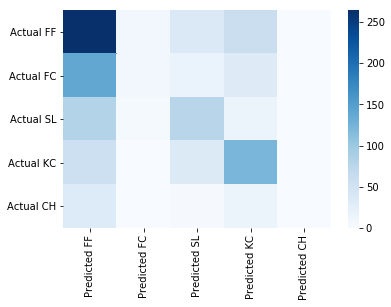

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,264,9,38,60,0
Actual FC,140,9,18,33,1
Actual SL,82,5,78,16,0
Actual KC,56,0,36,122,0
Actual CH,35,1,4,16,1


In [31]:
# model = rfc_with_bootstrap_search.best_estimator_
model = top10_rfc_bootstrap.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [32]:
# model.fit(X, y)
# y_pred = model.predict(X_test)
# pd.Series(y_pred).value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels

              precision    recall  f1-score   support

          FF       0.45      0.71      0.55       371
          FC       0.44      0.05      0.10       201
          SL       0.44      0.34      0.38       181
          KC       0.47      0.60      0.53       214
          CH       0.00      0.00      0.00        57

   micro avg       0.46      0.46      0.46      1024
   macro avg       0.36      0.34      0.31      1024
weighted avg       0.43      0.46      0.40      1024



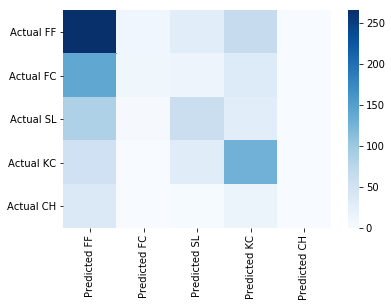

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,265,10,30,66,0
Actual FC,141,11,14,35,0
Actual SL,86,4,61,30,0
Actual KC,54,0,31,129,0
Actual CH,38,0,3,16,0


In [33]:
# model = search.best_estimator_
model = top10_rfc_without_bootstrap.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## XGBoost

In [43]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 352kB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
from xgboost import XGBClassifier

num_classes = df[target].nunique()

param_grid = {
    'booster': ['gbtree', 'dart'],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma': [5, 10, 15, 20, 25, 0, 0.5, 1, 3],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'min_child_weight': [0, 0.5, 1, 2, 4, 8],
    'max_delta_step': [0, 1, 2, 3, 6, 10],
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'colsample_bynode': [0.8, 0.9, 1.0]    
}

xgb = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, num_class=num_classes, objective='multi:softmax')


xgb_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=200, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, random_state=12, 
                            error_score='raise-deprecating', return_train_score=True)

xgb_search.fit(X, y)

xgb_search_results = pd.DataFrame(xgb_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [45]:
xgb_search_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_max_delta_step,param_gamma,param_eta,param_colsample_bytree,param_colsample_bynode,param_colsample_bylevel,param_booster,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
36,8.820784,0.197227,0.051132,0.017710,8,2,6,10,0.4,0.9,0.9,0.9,gbtree,"{'min_child_weight': 8, 'max_depth': 2, 'max_d...",0.406121,0.471143,0.416274,0.431180,0.028564,1,0.515321,0.489838,0.525169,0.510109,0.014887
132,8.677866,0.025958,0.035403,0.000704,0,2,10,25,0.1,0.9,0.9,0.9,gbtree,"{'min_child_weight': 0, 'max_depth': 2, 'max_d...",0.412007,0.464075,0.415684,0.430591,0.023728,2,0.493518,0.472459,0.510156,0.492044,0.015425
66,28.368081,0.381132,0.041997,0.000378,1,8,1,25,0.4,0.9,0.8,0.8,dart,"{'min_child_weight': 1, 'max_depth': 8, 'max_d...",0.412596,0.461131,0.417453,0.430395,0.021827,3,0.500295,0.473932,0.512511,0.495579,0.016099
40,14.808354,0.211108,0.042366,0.000615,0,4,1,20,0.3,0.9,0.8,0.8,dart,"{'min_child_weight': 0, 'max_depth': 4, 'max_d...",0.409064,0.458186,0.422170,0.429806,0.020772,4,0.504714,0.481591,0.511628,0.499311,0.012844
82,8.220745,0.295464,0.048901,0.019453,0,2,0,20,0.4,0.8,1,0.8,gbtree,"{'min_child_weight': 0, 'max_depth': 2, 'max_d...",0.407887,0.461720,0.417453,0.429020,0.023453,5,0.493518,0.473343,0.512511,0.493124,0.015993
34,49.377382,0.637373,0.037862,0.000684,0.5,15,0,25,0.1,0.8,0.8,0.9,gbtree,"{'min_child_weight': 0.5, 'max_depth': 15, 'ma...",0.410830,0.442874,0.422759,0.425486,0.013226,6,0.500295,0.477172,0.515455,0.497641,0.015741
151,6.737836,0.148323,0.037322,0.001084,8,2,2,20,0.3,0.8,0.8,0.8,gbtree,"{'min_child_weight': 8, 'max_depth': 2, 'max_d...",0.406121,0.460542,0.408608,0.425093,0.025090,7,0.496170,0.478645,0.509273,0.494696,0.012547
77,18.732217,0.128198,0.043481,0.009791,8,6,2,25,0.4,0.9,0.8,0.8,gbtree,"{'min_child_weight': 8, 'max_depth': 6, 'max_d...",0.398470,0.442874,0.431604,0.424308,0.018851,8,0.504714,0.474816,0.514572,0.498034,0.016904
165,8.099908,0.271161,0.037012,0.001217,2,2,3,20,0.1,0.9,0.9,0.8,gbtree,"{'min_child_weight': 2, 'max_depth': 2, 'max_d...",0.408476,0.452886,0.410967,0.424112,0.020375,9,0.492634,0.477467,0.512217,0.494106,0.014225
81,29.792987,0.620314,0.048161,0.004316,0,8,10,25,0.5,0.9,0.8,0.8,dart,"{'min_child_weight': 0, 'max_depth': 8, 'max_d...",0.414361,0.438163,0.417453,0.423326,0.010568,10,0.500589,0.475994,0.516044,0.497542,0.016491


In [46]:
%%time
top10_xgb = get_top_n_models(xgb_search_results, 'xgb', k=30)

CPU times: user 23min 23s, sys: 11.9 s, total: 23min 35s
Wall time: 1min 28s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          FF       0.45      0.81      0.57       371
          FC       0.00      0.00      0.00       201
          SL       0.45      0.40      0.42       181
          KC       0.55      0.50      0.52       214
          CH       0.00      0.00      0.00        57

   micro avg       0.47      0.47      0.47      1024
   macro avg       0.29      0.34      0.30      1024
weighted avg       0.36      0.47      0.39      1024



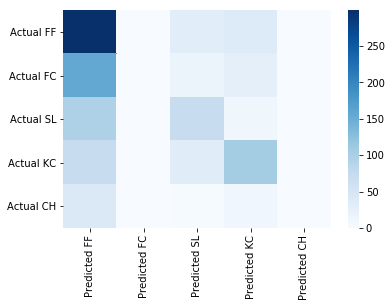

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,299,0,33,39,0
Actual FC,157,0,17,27,0
Actual SL,97,0,72,12,0
Actual KC,73,0,34,107,0
Actual CH,43,0,3,11,0


In [47]:
# model = search.best_estimator_
model = top10_xgb.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Support Vector Machine

In [52]:
%%time
from sklearn.svm import SVC

param_grid = {
    'degree': [2,3,4],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0001, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'shrinking': [True, False],
    'class_weight': ['balanced', None],
    'max_iter': [100, 250, 400, 700, 1200, 2000, 3500],
    'decision_function_shape': ['ovo', 'ovr'],
    'gamma': ['auto', 'scale']
}

svm = SVC(random_state=42, verbose=50)

# svm_search = GridSearchCV(
#     estimator = svm, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=3,
#     verbose=10,
#     return_train_score=True
# )

svm_search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=400, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

svm_search.fit(X, y)

svm_search_results = pd.DataFrame(svm_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 130 tasks      |

[LibSVM]CPU times: user 21.4 s, sys: 691 ms, total: 22.1 s
Wall time: 12min 44s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [53]:
svm_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_shrinking,param_max_iter,param_kernel,param_gamma,param_degree,param_decision_function_shape,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
132,8.383509,0.119384,3.081462,0.062146,1e-05,False,2000,rbf,scale,2,ovo,None,5,"{'tol': 1e-05, 'shrinking': False, 'max_iter':...",0.454385,0.471143,0.437500,0.454349,0.013732,1,0.501473,0.469514,0.515455,0.495481,0.019228
399,7.405394,0.174031,1.873928,0.118834,1e-05,True,3500,rbf,scale,2,ovr,None,3.5,"{'tol': 1e-05, 'shrinking': True, 'max_iter': ...",0.443202,0.461720,0.436910,0.447281,0.010530,2,0.473777,0.450368,0.495437,0.473194,0.018404
394,8.587831,0.062834,2.778763,0.017007,0.0001,True,1200,rbf,scale,3,ovr,None,3.5,"{'tol': 0.0001, 'shrinking': True, 'max_iter':...",0.443202,0.461131,0.436910,0.447084,0.010260,3,0.473777,0.450074,0.495437,0.473096,0.018526
217,8.143470,0.143888,3.012065,0.045390,1e-05,False,2000,rbf,auto,3,ovr,None,2,"{'tol': 1e-05, 'shrinking': False, 'max_iter':...",0.432019,0.469376,0.420991,0.440801,0.020704,4,0.614319,0.592047,0.608184,0.604850,0.009393
246,8.826118,0.236243,2.871889,0.023012,1e-05,False,2000,rbf,auto,2,ovo,None,2,"{'tol': 1e-05, 'shrinking': False, 'max_iter':...",0.432019,0.469376,0.420991,0.440801,0.020704,4,0.614319,0.592047,0.608184,0.604850,0.009393


In [54]:
%%time
top10_svm = get_top_n_models(svm_search_results, 'svm', k=30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or M

CPU times: user 5min 43s, sys: 129 ms, total: 5min 43s
Wall time: 5min 43s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

              precision    recall  f1-score   support

          FF       0.44      0.74      0.55       371
          FC       0.50      0.00      0.01       201
          SL       0.46      0.30      0.36       181
          KC       0.46      0.60      0.52       214
          CH       0.00      0.00      0.00        57

   micro avg       0.45      0.45      0.45      1024
   macro avg       0.37      0.33      0.29      1024
weighted avg       0.44      0.45      0.38      1024



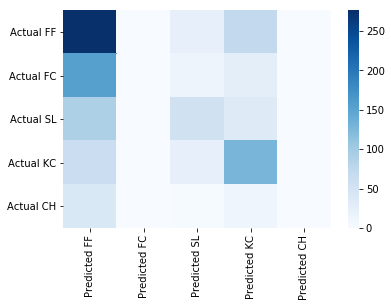

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,276,0,23,72,0
Actual FC,156,1,15,29,0
Actual SL,91,1,54,35,0
Actual KC,62,0,23,129,0
Actual CH,41,0,3,13,0


In [55]:
# model = search.best_estimator_
model = top10_svm.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Linear SVC

In [56]:
%%time
from sklearn.svm import LinearSVC

#L1 Regularization

param_grid = {
    'penalty': ['l1'],
    'loss': ['squared_hinge'],
    'dual': [False],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': [None, 'balanced'],
    'max_iter': [50, 100, 250, 400, 700, 1200, 2000],
    'fit_intercept': [True, False]
}

l1_LinSVC = LinearSVC(random_state=42, verbose=50)

l1_LinSVC_search = GridSearchCV(
    estimator = l1_LinSVC, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True
)

# l1_LinSVC_search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=500, 
#                             scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=4, verbose=10, 
#                             random_state=42, error_score='raise-deprecating', return_train_score=True)


l1_LinSVC_search.fit(X, y)
l1_LinSVC_search_results = pd.DataFrame(l1_LinSVC_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[LibLinear]CPU times: user 21 s, sys: 966 ms, total: 21.9 s
Wall time: 10min 42s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [57]:
l1_LinSVC_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_fit_intercept,param_loss,param_max_iter,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
38,9.079489,0.029625,0.004162,0.000080,0.2,None,False,False,squared_hinge,1200,l1,1e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.380812,0.462309,0.419222,0.420774,0.033297,1,0.573365,0.555228,0.574625,0.567739,0.008862
37,9.140771,0.075443,0.004114,0.000099,0.2,None,False,False,squared_hinge,1200,l1,5e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.380812,0.462309,0.419222,0.420774,0.033297,1,0.573365,0.555228,0.574625,0.567739,0.008862
23,0.532129,0.002201,0.004059,0.000039,0.2,None,False,False,squared_hinge,50,l1,1e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.377281,0.464075,0.419222,0.420185,0.035449,3,0.573070,0.551988,0.572564,0.565874,0.009821
22,0.537577,0.002728,0.004065,0.000028,0.2,None,False,False,squared_hinge,50,l1,5e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.377281,0.464075,0.419222,0.420185,0.035449,3,0.573070,0.551988,0.572564,0.565874,0.009821
21,0.537219,0.005079,0.004081,0.000022,0.2,None,False,False,squared_hinge,50,l1,0.0001,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.377281,0.464075,0.419222,0.420185,0.035449,3,0.573070,0.551988,0.572564,0.565874,0.009821


In [58]:
%%time
top10_l1_LinSVC = get_top_n_models(l1_LinSVC_search_results, 'lin_SVC', k=30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

CPU times: user 3min 27s, sys: 2.32 s, total: 3min 30s
Wall time: 2min 49s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

          FF       0.46      0.69      0.55       371
          FC       0.25      0.10      0.14       201
          SL       0.40      0.31      0.35       181
          KC       0.49      0.49      0.49       214
          CH       0.19      0.14      0.16        57

   micro avg       0.43      0.43      0.43      1024
   macro avg       0.36      0.34      0.34      1024
weighted avg       0.40      0.43      0.40      1024



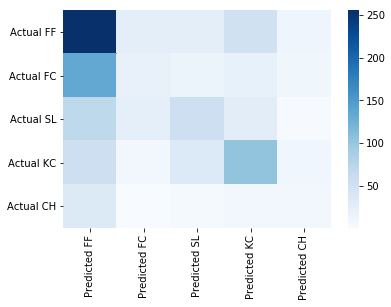

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,255,26,27,51,12
Actual FC,134,20,15,21,11
Actual SL,71,24,56,28,2
Actual KC,56,8,36,104,10
Actual CH,35,1,5,8,8


In [59]:
# model = search.best_estimator_
model = top10_l1_LinSVC.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [60]:
%%time
from sklearn.svm import LinearSVC

#L2 Regularization

#The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

param_grid = {
    'penalty': ['l2'],#, 'l1'],
    'loss': ['squared_hinge'],# 'hinge'],
    'dual': [True],# False],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': ['balanced', None],
    'max_iter': [50, 100, 250, 400, 700, 1200],
    'fit_intercept': [True]#, False]
}

l2_LinSVC = LinearSVC(random_state=42, verbose=50)

# l2_LinSVC_search_A = GridSearchCV(
#     estimator = l2_LinSVC, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )

l2_LinSVC_search_A = RandomizedSearchCV(estimator=l2_LinSVC, param_distributions=param_grid, n_iter=250, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

l2_LinSVC_search_A.fit(X, y)
l2_LinSVC_search_results_A = pd.DataFrame(l2_LinSVC_search_A.cv_results_).sort_values(by='rank_test_score')

param_grid = {
    'penalty': ['l2'],
    'loss': ['hinge'],
    'dual': [True],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': ['balanced', None],
    'max_iter': [50, 100, 250, 400, 700, 1200],
    'fit_intercept': [True]#, False]
}

# l2_LinSVC_search_B = GridSearchCV(
#     estimator = l2_LinSVC, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )

l2_LinSVC_search_B = RandomizedSearchCV(estimator=l2_LinSVC, param_distributions=param_grid, n_iter=250, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

l2_LinSVC_search_B.fit(X, y)
l2_LinSVC_search_results_B = pd.DataFrame(l2_LinSVC_search_B.cv_results_).sort_values(by='rank_test_score')


l2_LinSVC_search_results = pd.concat([l2_LinSVC_search_results_A, l2_LinSVC_search_results_B]).sort_values(by='rank_test_score')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 216 is smaller than n_iter=250. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Paralle

[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 216 is smaller than n_iter=250. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Paralle

[LibLinear]CPU times: user 20.4 s, sys: 549 ms, total: 21 s
Wall time: 6min 2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [61]:
l2_LinSVC_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_penalty,param_max_iter,param_loss,param_fit_intercept,param_dual,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
27,4.022266,0.049634,0.004662,0.000077,0.0001,l2,400,squared_hinge,True,True,None,0.2,"{'tol': 0.0001, 'penalty': 'l2', 'max_iter': 4...",0.406121,0.432862,0.415094,0.418025,0.011114,1,0.561874,0.549632,0.529585,0.547030,0.013310
29,3.975286,0.110265,0.004726,0.000222,1e-05,l2,400,squared_hinge,True,True,None,0.2,"{'tol': 1e-05, 'penalty': 'l2', 'max_iter': 40...",0.406121,0.432862,0.415094,0.418025,0.011114,1,0.561874,0.549632,0.529585,0.547030,0.013310
28,3.986700,0.073819,0.004628,0.000071,5e-05,l2,400,squared_hinge,True,True,None,0.2,"{'tol': 5e-05, 'penalty': 'l2', 'max_iter': 40...",0.406121,0.432862,0.415094,0.418025,0.011114,1,0.561874,0.549632,0.529585,0.547030,0.013310
35,9.892938,0.239682,0.004656,0.000049,1e-05,l2,1200,hinge,True,True,None,0.2,"{'tol': 1e-05, 'penalty': 'l2', 'max_iter': 12...",0.371395,0.451119,0.425708,0.416061,0.033261,1,0.554803,0.514286,0.548425,0.539171,0.017788
34,9.882869,0.074493,0.004704,0.000038,5e-05,l2,1200,hinge,True,True,None,0.2,"{'tol': 5e-05, 'penalty': 'l2', 'max_iter': 12...",0.371395,0.451119,0.425708,0.416061,0.033261,1,0.554803,0.514286,0.548425,0.539171,0.017788


In [62]:
%%time
top10_l2_LinSVC = get_top_n_models(l2_LinSVC_search_results, 'lin_SVC', k=30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

CPU times: user 3min 17s, sys: 2.38 s, total: 3min 19s
Wall time: 2min 39s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

          FF       0.45      0.68      0.54       371
          FC       0.24      0.16      0.19       201
          SL       0.38      0.27      0.31       181
          KC       0.48      0.31      0.38       214
          CH       0.09      0.09      0.09        57

   micro avg       0.39      0.39      0.39      1024
   macro avg       0.33      0.30      0.30      1024
weighted avg       0.38      0.39      0.37      1024



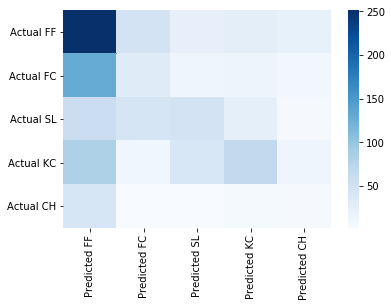

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,251,48,23,27,22
Actual FC,130,33,13,15,10
Actual SL,58,45,48,25,5
Actual KC,82,11,41,67,13
Actual CH,42,2,2,6,5


In [63]:
# model = search.best_estimator_
model = top10_l2_LinSVC.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [64]:
#get_accuracy_metrics(model, X, y, X_test, y_test)

## SGDClassifier

In [65]:
%%time
from sklearn.linear_model import SGDClassifier

param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.02, .05, 0.1],
    'loss': ['log', 'hinge', 'squared_hinge'],# 'modified_huber', 'perceptron'],
    'tol': [0.0001, 0.00005, 0.00001],
    'class_weight': ['balanced', None],
    'max_iter': [1000, 3000, 5000, 10000, 20000, 40000, 100000, 200000],
    'fit_intercept': [True, False],
    'warm_start': [True, False],
    'learning_rate': ['optimal'],
    'shuffle':[True, False]
}

sgd = SGDClassifier(random_state=42, verbose=50)

# search = GridSearchCV(
#     estimator = sgd, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )


sgd_search = RandomizedSearchCV(estimator=sgd, param_distributions=param_grid, n_iter=200, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

sgd_search.fit(X, y)

sgd_search_results = pd.DataFrame(sgd_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
-- Epoch 1
Norm: 2.58, NNZs: 253, Bias: 1.121090, T: 5093, Avg. loss: 26.897463
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.81, NNZs: 253, Bias: 1.124985, T: 10186, Avg. loss: 2.478462
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.47, NNZs: 253, Bias: 1.081564, T: 15279, Avg. loss: 1.444790
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.31, NNZs: 253, Bias: 1.065300, T: 20372, Avg. loss: 1.109424
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 1.22, NNZs: 253, Bias: 1.041011, T: 25465, Avg. loss: 0.941720
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 1.15, NNZs: 253, Bias: 1.035088, T: 30558, Avg. loss: 0.829169
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 1.09, NNZs: 253, Bias: 1.027378, T: 35651, Avg. loss: 0.774251
Total training time: 0.03 seconds.
-- Epoch 8
Norm: 1.05, NNZs: 253, Bias: 1.019003, T: 40744, Avg. loss: 0.750951
Total training time: 0.04 seconds.

In [66]:
sgd_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_tol,param_shuffle,param_penalty,param_max_iter,param_loss,param_learning_rate,param_fit_intercept,param_class_weight,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
32,1.488549,0.048060,0.005648,0.000081,True,0.0001,True,l2,20000,log,optimal,True,None,0.05,"{'warm_start': True, 'tol': 0.0001, 'shuffle':...",0.443202,0.475265,0.443396,0.453956,0.015070,1,0.517089,0.492784,0.520754,0.510209,0.012412
71,1.563821,0.045572,0.005891,0.000140,False,0.0001,True,l2,40000,log,optimal,True,None,0.05,"{'warm_start': False, 'tol': 0.0001, 'shuffle'...",0.443202,0.475265,0.443396,0.453956,0.015070,1,0.517089,0.492784,0.520754,0.510209,0.012412
189,1.060052,0.045013,0.005548,0.000056,False,1e-05,True,l2,100000,hinge,optimal,False,None,0.1,"{'warm_start': False, 'tol': 1e-05, 'shuffle':...",0.442613,0.476443,0.410377,0.443157,0.026969,3,0.516794,0.499853,0.491021,0.502556,0.010694
151,2.065994,0.375096,0.005789,0.000080,False,0.0001,True,elasticnet,40000,log,optimal,True,None,0.05,"{'warm_start': False, 'tol': 0.0001, 'shuffle'...",0.424956,0.466431,0.433962,0.441783,0.017815,4,0.464643,0.449190,0.511334,0.475056,0.026417
1,2.093490,0.384122,0.005795,0.000181,True,0.0001,True,elasticnet,40000,log,optimal,True,None,0.02,"{'warm_start': True, 'tol': 0.0001, 'shuffle':...",0.452031,0.458775,0.402123,0.437660,0.025260,5,0.499705,0.482180,0.463056,0.481647,0.014967


In [67]:
%%time
top10_sgd = get_top_n_models(sgd_search_results, 'sgd', k=30, accuracy_metric='accuracy')

CPU times: user 1min 21s, sys: 2.6 s, total: 1min 24s
Wall time: 43.5 s


In [68]:
top10_sgd

,model,accuracy,balanced_accuracy,f1_score,r2_score,roc_auc_score,model_type
0,"SGDClassifier(alpha=0.05, average=False, class...",0.445312,0.321193,N/A,-0.497735,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.05, average=False, class...",0.445312,0.321193,N/A,-0.497735,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.02, average=False, class...",0.442383,0.350308,N/A,-0.388153,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.02, average=False, class...",0.439453,0.340264,N/A,-0.427970,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.02, average=False, class...",0.439453,0.340264,N/A,-0.427970,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.02, average=False, class...",0.438477,0.344896,N/A,-0.389514,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.433594,0.308018,N/A,-0.581112,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.05, average=False, class...",0.427734,0.350818,N/A,-0.622971,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.424805,0.306374,N/A,-0.376582,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.001, average=False, clas...",0.421875,0.345999,N/A,-0.727449,N/A,SGDClassifier


              precision    recall  f1-score   support

          FF       0.42      0.78      0.55       371
          FC       0.00      0.00      0.00       201
          SL       0.45      0.29      0.36       181
          KC       0.51      0.50      0.51       214
          CH       0.00      0.00      0.00        57

   micro avg       0.44      0.44      0.44      1024
   macro avg       0.28      0.32      0.28      1024
weighted avg       0.34      0.44      0.37      1024



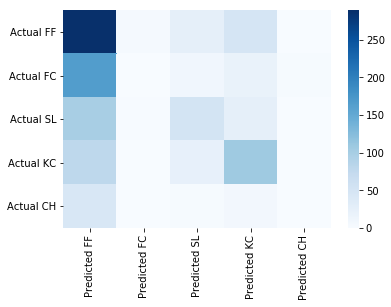

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,289,5,26,50,1
Actual FC,166,0,11,21,3
Actual SL,100,2,53,26,0
Actual KC,80,1,24,108,1
Actual CH,46,0,3,8,0


In [69]:
# model = search.best_estimator_
model = top10_sgd.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## LDA

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {
    'solver': ['lsqr'],#, 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5],
    'tol': [0.0001, 0.00005, 0.00001],
    'n_components':[None, 25, 50, 75, 100],
    #'store_covariance': [True, False]
}

lda = LinearDiscriminantAnalysis()

lda_search = GridSearchCV(
    estimator = lda, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=8,
    verbose=10,
    return_train_score=True
)

lda_search.fit(X, y)

lda_search_results = pd.DataFrame(lda_search.cv_results_).sort_values(by='rank_test_score')

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [71]:
lda_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
44,0.277161,0.002804,0.003063,0.000266,75,0.1,lsqr,1e-05,"{'n_components': 75, 'shrinkage': 0.1, 'solver...",0.425665,0.488263,0.492138,0.498428,0.465409,0.446541,0.413522,0.464567,0.46181,0.029272,1,0.516614,0.504266,0.506394,0.5046,0.505721,0.508414,0.514023,0.508973,0.508626,0.004209
20,0.273771,0.006070,0.002852,0.000417,25,0.1,lsqr,1e-05,"{'n_components': 25, 'shrinkage': 0.1, 'solver...",0.425665,0.488263,0.492138,0.498428,0.465409,0.446541,0.413522,0.464567,0.46181,0.029272,1,0.516614,0.504266,0.506394,0.5046,0.505721,0.508414,0.514023,0.508973,0.508626,0.004209
43,0.269106,0.004511,0.002886,0.000248,75,0.1,lsqr,5e-05,"{'n_components': 75, 'shrinkage': 0.1, 'solver...",0.425665,0.488263,0.492138,0.498428,0.465409,0.446541,0.413522,0.464567,0.46181,0.029272,1,0.516614,0.504266,0.506394,0.5046,0.505721,0.508414,0.514023,0.508973,0.508626,0.004209
42,0.278989,0.004383,0.003017,0.000306,75,0.1,lsqr,0.0001,"{'n_components': 75, 'shrinkage': 0.1, 'solver...",0.425665,0.488263,0.492138,0.498428,0.465409,0.446541,0.413522,0.464567,0.46181,0.029272,1,0.516614,0.504266,0.506394,0.5046,0.505721,0.508414,0.514023,0.508973,0.508626,0.004209
30,0.278465,0.011242,0.002969,0.000173,50,0.1,lsqr,0.0001,"{'n_components': 50, 'shrinkage': 0.1, 'solver...",0.425665,0.488263,0.492138,0.498428,0.465409,0.446541,0.413522,0.464567,0.46181,0.029272,1,0.516614,0.504266,0.506394,0.5046,0.505721,0.508414,0.514023,0.508973,0.508626,0.004209


In [72]:
%%time
top10_lda = get_top_n_models(lda_search_results, 'lda', k=60)
top10_lda

CPU times: user 1min 4s, sys: 3.02 s, total: 1min 7s
Wall time: 8.4 s


              precision    recall  f1-score   support

          FF       0.45      0.73      0.55       371
          FC       0.27      0.04      0.07       201
          SL       0.47      0.31      0.37       181
          KC       0.47      0.52      0.50       214
          CH       0.11      0.07      0.09        57

   micro avg       0.44      0.44      0.44      1024
   macro avg       0.35      0.33      0.32      1024
weighted avg       0.40      0.44      0.39      1024



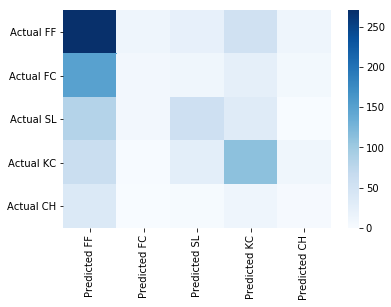

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,270,12,23,54,12
Actual FC,150,8,11,25,7
Actual SL,83,8,56,33,1
Actual KC,62,2,27,112,11
Actual CH,38,0,3,12,4


In [73]:
model = top10_lda.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## K-Nearest Neighbors

In [74]:
%%time
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1,2,3]
}

knn = KNeighborsClassifier()

# search = GridSearchCV(
#     estimator = knn, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )


knn_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=150, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

knn_search.fit(X, y)

knn_search_results = pd.DataFrame(knn_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed: 1

CPU times: user 3.25 s, sys: 155 ms, total: 3.4 s
Wall time: 24min 44s


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 24.7min finished


In [75]:
knn_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_p,param_n_neighbors,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
8,0.065308,0.001426,2.762503,0.075232,uniform,1,6,30,auto,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.400235,0.388104,0.362028,0.383468,0.015938,1,0.601945,0.580265,0.557845,0.580018,0.018004
96,0.052698,0.003660,1.984219,0.108632,uniform,1,6,30,ball_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.400235,0.388104,0.362028,0.383468,0.015938,1,0.601945,0.580265,0.557845,0.580018,0.018004
13,0.013361,0.001586,1.034954,0.027797,uniform,1,6,50,brute,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.400235,0.388104,0.362028,0.383468,0.015938,1,0.601945,0.580265,0.557845,0.580018,0.018004
130,0.048941,0.003506,2.624460,0.008167,uniform,1,7,30,auto,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.400235,0.391637,0.355542,0.382486,0.019359,4,0.591927,0.574669,0.559611,0.575402,0.013203
109,0.053774,0.000873,2.630787,0.009865,uniform,1,7,40,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.400235,0.391637,0.355542,0.382486,0.019359,4,0.591927,0.574669,0.559611,0.575402,0.013203


In [76]:
%%time
top10_knn = get_top_n_models(knn_search_results, 'knn', k=20)
top10_knn

CPU times: user 53.3 s, sys: 412 ms, total: 53.7 s
Wall time: 53.7 s


              precision    recall  f1-score   support

          FF       0.45      0.71      0.55       371
          FC       0.25      0.16      0.20       201
          SL       0.35      0.15      0.21       181
          KC       0.46      0.43      0.45       214
          CH       0.18      0.09      0.12        57

   micro avg       0.41      0.41      0.41      1024
   macro avg       0.34      0.31      0.31      1024
weighted avg       0.38      0.41      0.38      1024



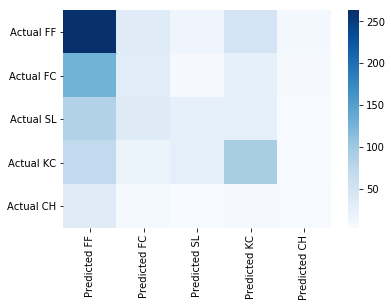

,Predicted FF,Predicted FC,Predicted SL,Predicted KC,Predicted CH
Actual FF,263,35,15,49,9
Actual FC,128,33,7,26,7
Actual SL,85,36,28,28,4
Actual KC,72,18,28,93,3
Actual CH,34,8,3,7,5


In [77]:
model = top10_knn.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Logistic Regression:

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l2'],
    'dual': [False],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'fit_intercept': [True, False], 
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [1000, 3000, 5000, 10000, 20000, 40000, 100000],
    'multi_class': ['ovr', 'auto'], 
    'warm_start': [True, False]
    
}

lr = LogisticRegression(random_state=42, n_jobs=-1)

# search = GridSearchCV(
#     estimator = knn, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )


lr_search = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, n_iter=150, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

lr_search.fit(X, y)

lr_search_results = pd.DataFrame(lr_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [ ]:
lr_search_results.head()

In [ ]:
lr_search_results.tail()

In [ ]:
%%time
top10_lr = get_top_n_models(lr_search_results, 'lr', k=20)
top10_lr

In [ ]:
model = top10_lr.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Save the work

In [89]:
#combine all the top10s into one df and save to pickle file

best_models = pd.concat([top10_rfc_bootstrap, top10_rfc_without_bootstrap, top10_xgb, top10_svm, top10_l1_LinSVC, top10_l2_LinSVC,
                         top10_sgd, top10_lda, top10_knn, top10_lr], sort=False).reset_index(drop=True)

In [91]:
# best_models.to_pickle(path=(pitcher+'_ordinal_multiclass_best_models_v1.pkl'),compression='zip')

best_models.to_pickle(path=(pitcher+'_onehot_multiclass_best_models_v1.pkl'),compression='zip')

# best_models.to_pickle(path=(pitcher+'_onehot_pca_multiclass_best_models_v1.pkl'),compression='zip')

In [93]:
# test = pd.read_pickle(pitcher+'multiclass_best_models_v1.pkl', compression='zip')
# test.sort_values(by='accuracy', ascending=False).head(20)